In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-bike-rental-ai-pro-iti/sample_submission.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Data fields

    ID - an ID for this instance
    Date - year-month-day
    Hour - Hour of he day
    Temperature - Temperature in Celsius
    Humidity - %
    Windspeed - m/s
    Visibility - 10m
    Dew point temperature - Celsius
    Solar radiation - MJ/m2
    Rainfall - mm
    Snowfall - cm
    Seasons - Winter, Spring, Summer, Autumn
    Holiday - Holiday/No holiday
    Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)
    y - Rented Bike count (Target), Count of bikes rented at each hour


In [3]:
# reading train and test data
dataset_path = '/kaggle/input/seoul-bike-rental-ai-pro-iti/'
train = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
test = pd.read_csv(os.path.join(dataset_path,'test.csv'))

train.rename(columns=lambda x:x.strip(),inplace=True)
# rename columns
names = {'Date':'date','Hour':'hour','Temperature(�C)':'temp',
        'Humidity(%)':'humidity','Visibility (10m)':'vis_10',
        'Dew point temperature(�C)':'dew_pt_temp','Solar Radiation (MJ/m2)':'solar_rad',
        'Rainfall(mm)':'rainfall_mm','Snowfall (cm)':'snowfall_cm','Seasons':'seasons','Holiday':'holiday',
        'Functioning Day':'functioning_day','Wind speed (m/s)':'windspeed'}

train = train.rename(columns=names)
train['date-dt'] = pd.to_datetime(train['date'])
train = train.reset_index()
train.head()

index  ID        date    y  hour  temp  humidity  windspeed  vis_10  \
0      0   0  01/12/2017  254     0  -5.2        37        2.2    2000   
1      1   1  01/12/2017  204     1  -5.5        38        0.8    2000   
2      2   2  01/12/2017  173     2  -6.0        39        1.0    2000   
3      3   3  01/12/2017  107     3  -6.2        40        0.9    2000   
4      4   4  01/12/2017   78     4  -6.0        36        2.3    2000   

   dew_pt_temp  solar_rad  rainfall_mm  snowfall_cm seasons     holiday  \
0        -17.6        0.0          0.0          0.0  Winter  No Holiday   
1        -17.6        0.0          0.0          0.0  Winter  No Holiday   
2        -17.7        0.0          0.0          0.0  Winter  No Holiday   
3        -17.6        0.0          0.0          0.0  Winter  No Holiday   
4        -18.6        0.0          0.0          0.0  Winter  No Holiday   

  functioning_day    date-dt  
0             Yes 2017-01-12  
1             Yes 2017-01-12  
2             Yes 2017-01-12  
3             Yes 2017-01-12  
4             Yes 2017-01-12

### target distribution

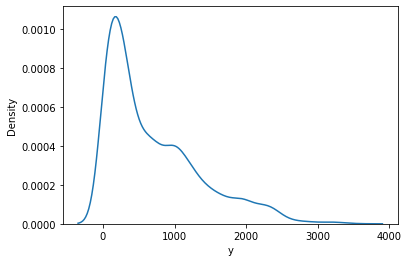

In [4]:
sns.kdeplot(x='y',data=train);

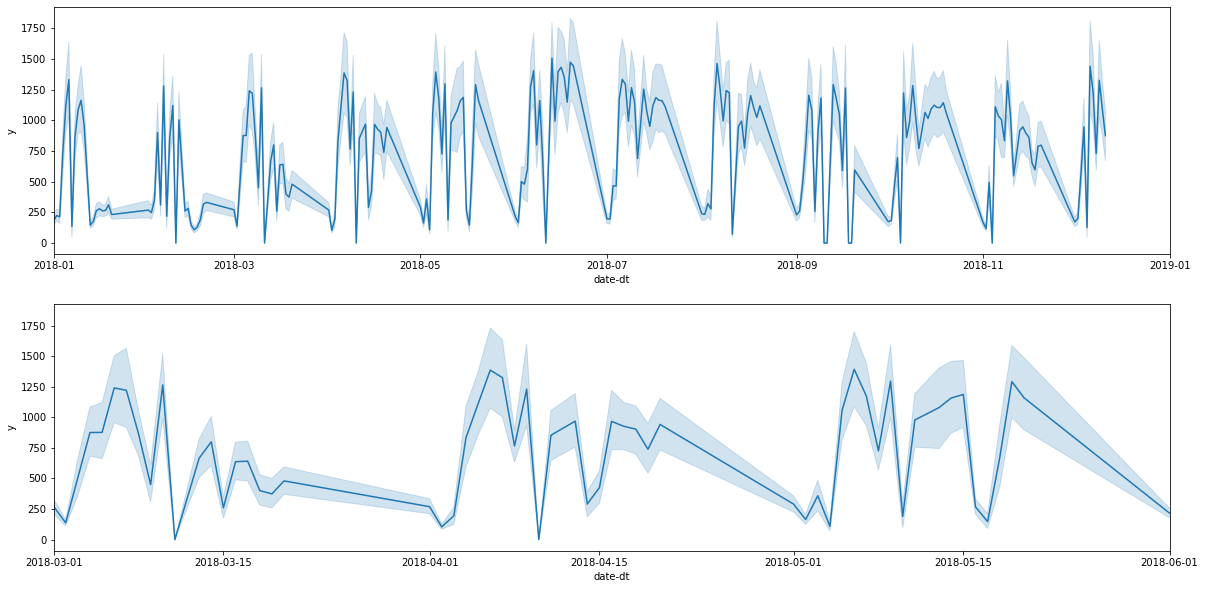

In [5]:
#plot distribution of data accross time
fig,ax = plt.subplots(2,figsize = (20,10))

ax1 = sns.lineplot(ax = ax[0],x=train['date-dt'],y=train['y'])
ax1.set_xlim([datetime.date(2018,1,1),datetime.date(2019,1,1)]);

ax1 = sns.lineplot(ax = ax[1],x=train['date-dt'],y=train['y'])
ax1.set_xlim([datetime.date(2018,3,1),datetime.date(2018,6,1)]);

**from the previous plot its obvious that the distribution of the y is seasonal lets look closer
it appears that the number of bickes spike by the start of the month and goes down by the end of the month<br>**
and it seems to be more crouded at the middle of the year<br>
although the number of bikes varies throught the month, each month is diffrent from the other<br>
and this makes us understand that year is irrilivant to the number of bikes<br><br>

lets examine other relations

## Tempreture

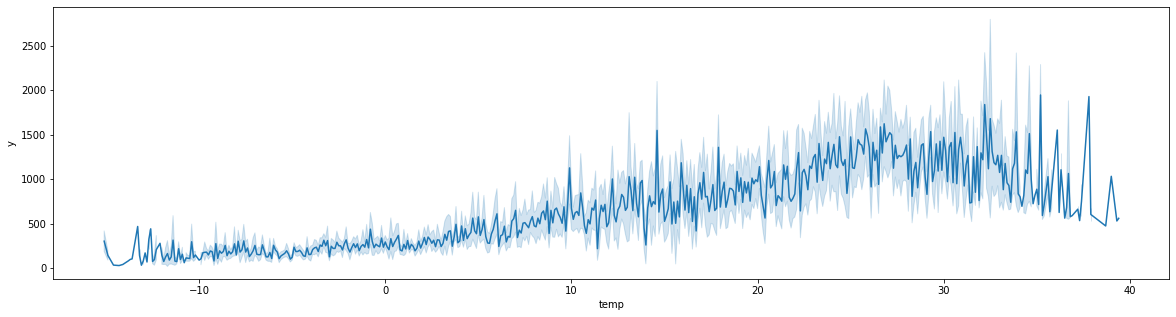

In [6]:
fig,ax = plt.subplots(figsize = (20,5))
ax = sns.lineplot(x=train['temp'],y=train['y'])

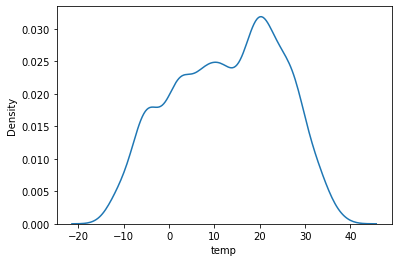

In [7]:
sns.kdeplot(x='temp',data=train);

The number of bikes tend to be the maximum around the 25-35 degree celcius which makes sense as this is the confortable tempreture for humans.<br><br>
This feature will have a big effect on predictions and we can do some enginnering and get lead and laging values for it.

## Visablity

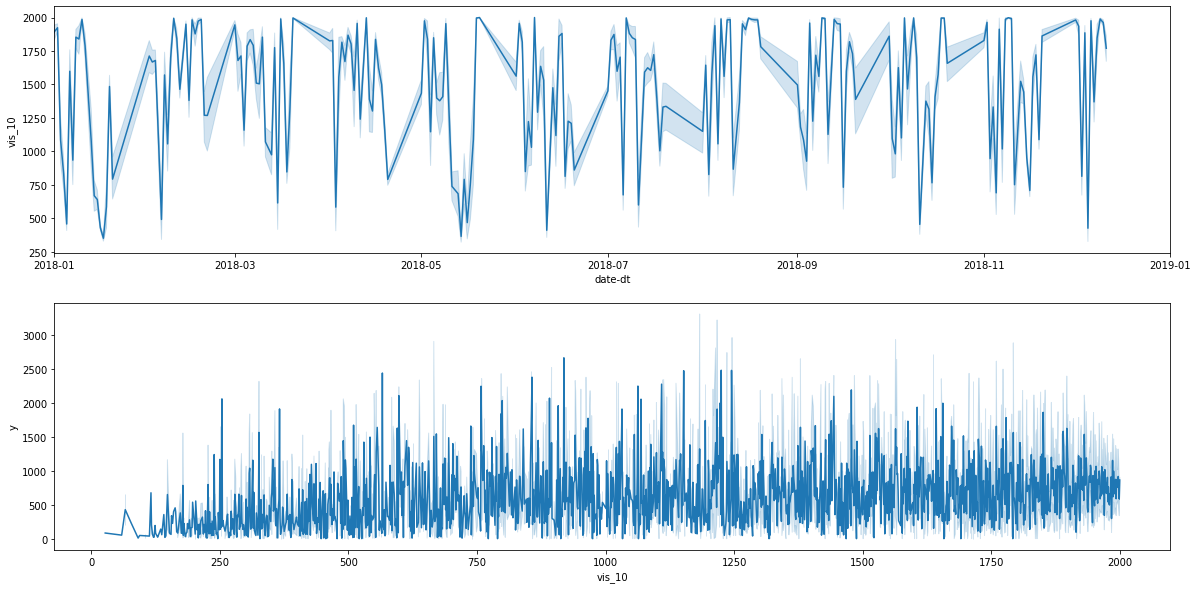

In [8]:
fig,ax = plt.subplots(2,figsize = (20,10))
ax1 = sns.lineplot(ax = ax[0],x=train['date-dt'],y=train['vis_10'])
ax1.set_xlim([datetime.date(2018,1,1),datetime.date(2019,1,1)]);

ax2 = sns.lineplot(ax=ax[1],x=train['vis_10'],y=train['y'])

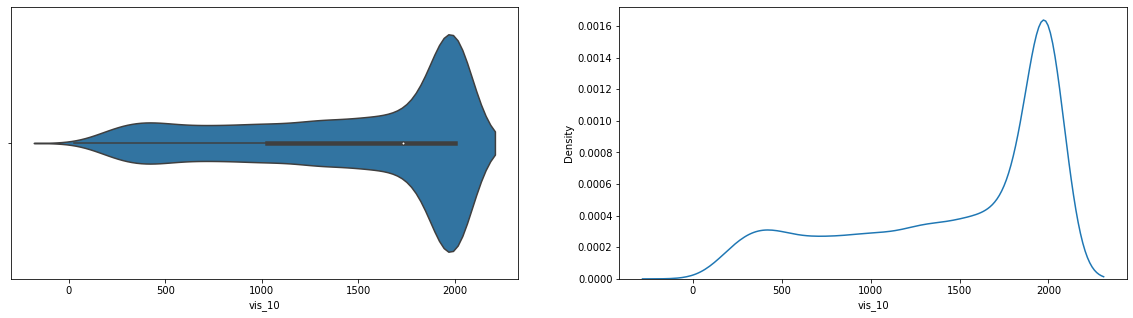

In [9]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
sns.violinplot(ax=ax[0],x='vis_10',data = train);
sns.kdeplot(ax=ax[1],x='vis_10',data=train);

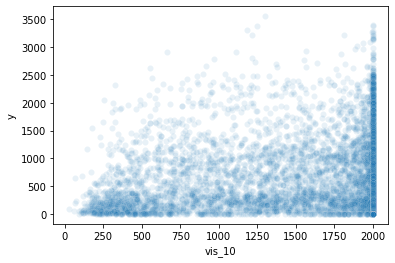

In [10]:
sns.scatterplot(x='vis_10',y='y',data=train,alpha = 0.1);

Visabilty data is centered around 2000 and most of the rents are at this range of visability ,but it isn't very comprehensive and noisy in order of time, so we can consider 3 things:<br>
1. dropping
2. denoise
3. monitor its effect on the model

## Dew point temp

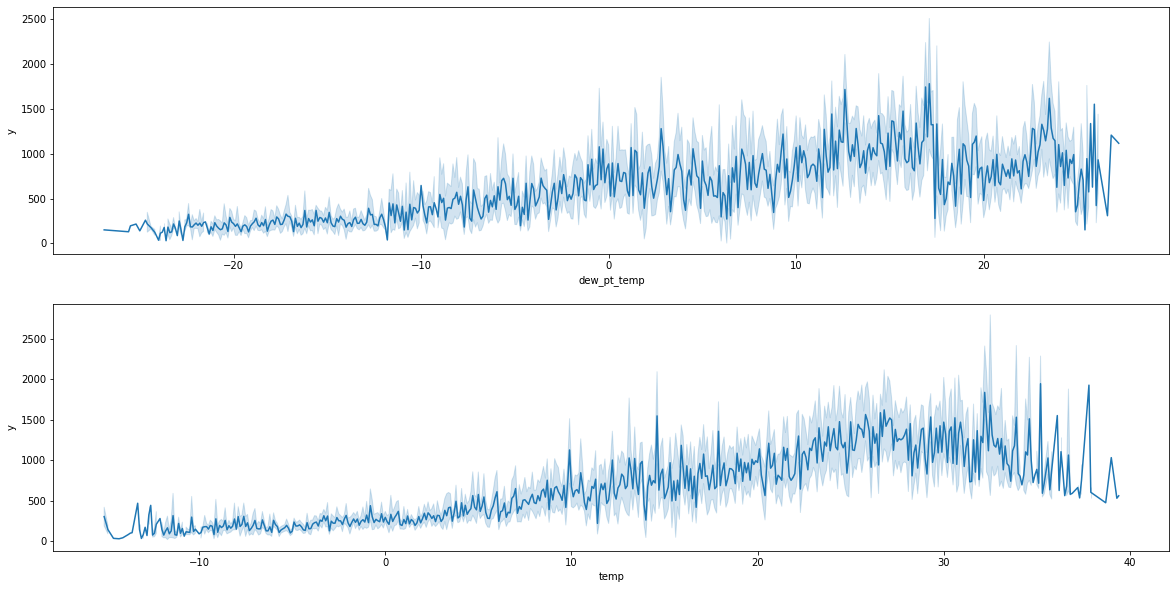

In [11]:
# dew temp
fig,ax = plt.subplots(2,figsize = (20,10))
sns.lineplot(ax = ax[0],x=train['dew_pt_temp'],y=train['y'])
sns.lineplot(ax = ax[1],x=train['temp'],y=train['y']);

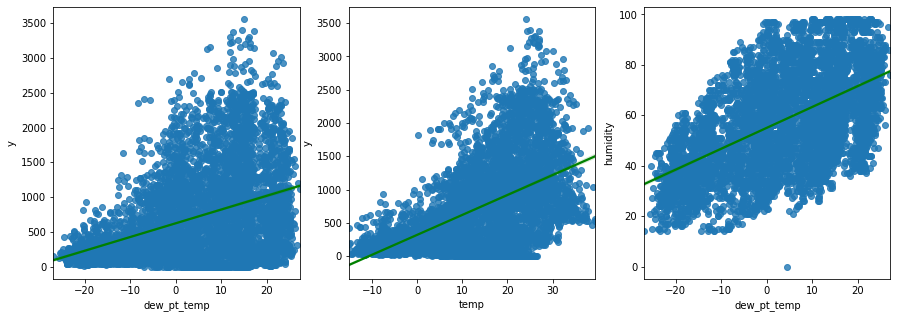

In [12]:
# due temp
fig,ax = plt.subplots(1,3,figsize = (15,5))
sns.regplot(ax=ax[0],x=train['dew_pt_temp'],y=train['y'],fit_reg=True,line_kws={'color':'green'})
sns.regplot(ax=ax[1],x=train['temp'],y=train['y'],fit_reg=True,line_kws={'color':'green'});
sns.regplot(ax=ax[2],x=train['dew_pt_temp'],y=train['humidity'],fit_reg=True,line_kws={'color':'green'});

Dew point tempreture and tempreture are nearly identical to each other in effect on the target variable<br><br>
Dew point by difination is :<br>
The dew point is the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100%. At this point the air cannot hold more water in the gas form.
<br><br>
therefor i think we can drop the dew temp as humidity and temp carry more comprehensive information about the rented bikes.<br>
And the dew point equation sugests that it is a linear combination of tempreture so it will be meaningless for the model.

## Hours

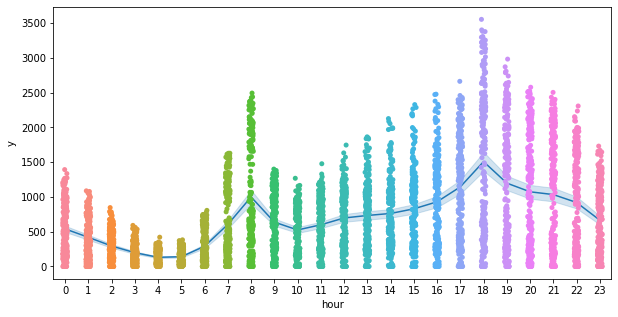

In [13]:
fig,ax = plt.subplots(figsize = (10,5))
sns.lineplot(x = train['hour'],y=train['y'])
plt.xlim([-1,25])
sns.stripplot(x=train['hour'],y=train['y']);

It appears that the hour of the day is critical to predicting the target variable, as the number of bikes rented is higher in mid day than early and night times.<br>
descion to be made:<br>
* dummies - normalization - leave as it is .(depending on the model)

## Solar radiation

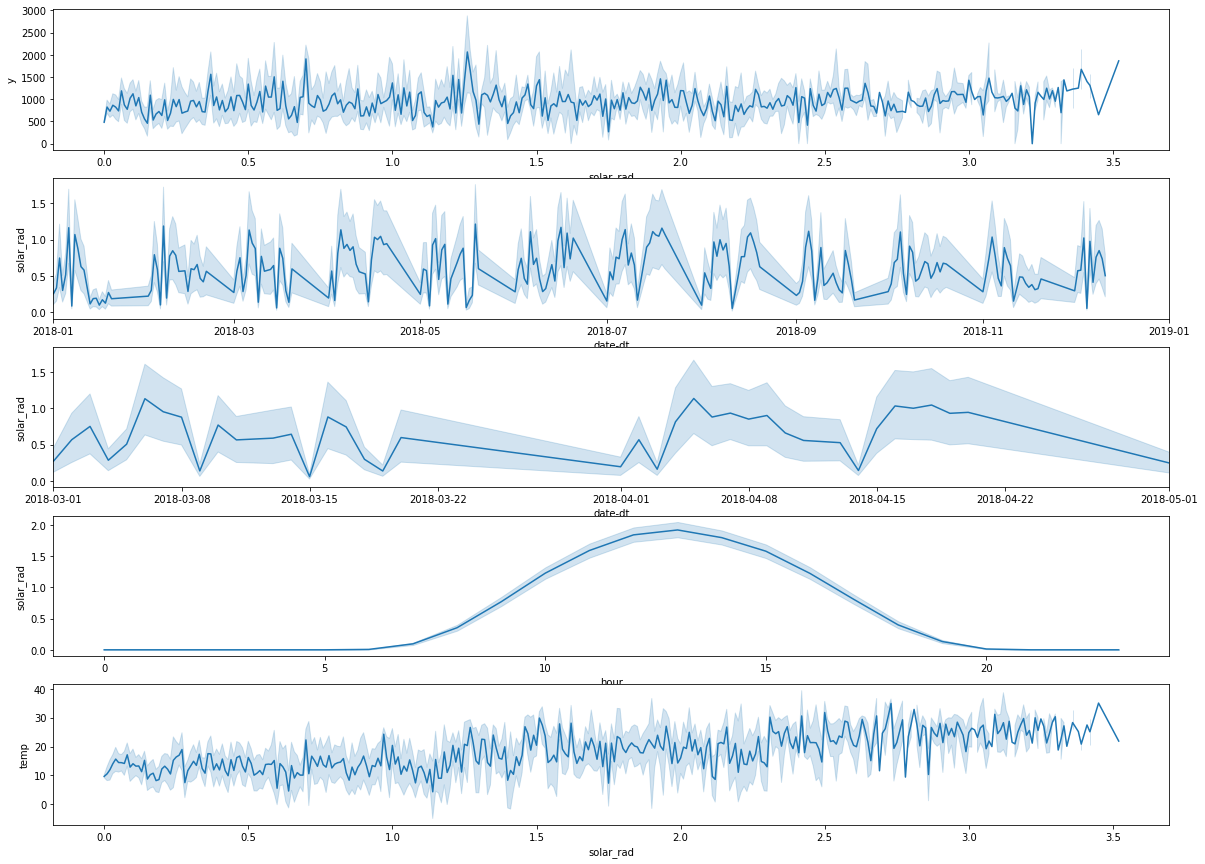

In [14]:
fig,ax = plt.subplots(5,figsize = (20,15))
ax1 = sns.lineplot(ax = ax[0],x = train['solar_rad'],y=train['y'])

ax2 = sns.lineplot(ax=ax[1],x=train['date-dt'],y=train['solar_rad'])
ax2.set_xlim([datetime.date(2018,1,1),datetime.date(2019,1,1)]);

ax3 = sns.lineplot(ax=ax[2],x=train['date-dt'],y=train['solar_rad'])
ax3.set_xlim([datetime.date(2018,3,1),datetime.date(2018,5,1)]);

ax3 = sns.lineplot(ax=ax[3],x=train['hour'],y=train['solar_rad'])
ax4 = sns.lineplot(ax = ax[4], x = train['solar_rad'],y=train['temp'])

<AxesSubplot:xlabel='solar_rad', ylabel='temp'>

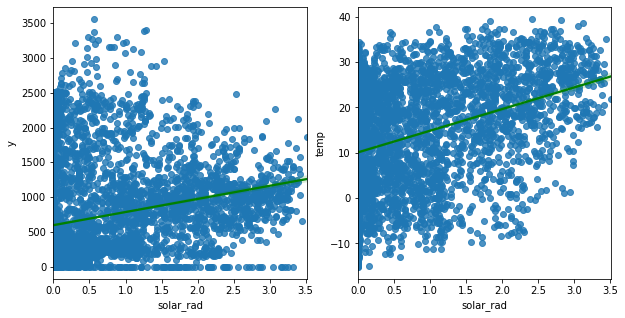

In [15]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.regplot(ax=ax[0],x=train['solar_rad'],y=train['y'],fit_reg=True,line_kws={'color':'green'})
sns.regplot(ax=ax[1],x=train['solar_rad'],y=train['temp'],fit_reg=True,line_kws={'color':'green'})

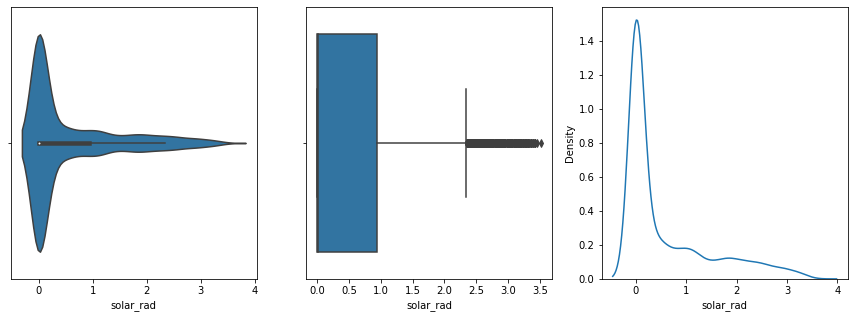

In [16]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
sns.violinplot(ax = ax[0],x=train['solar_rad'])
sns.boxplot(ax=ax[1], x=train['solar_rad'])
sns.kdeplot(ax=ax[2],x='solar_rad',data = train);

Solar radiation is centered around aprox. 0.2, and have alot of outliers.<br>
but these outliers are probably due to high tempretures in some days.<br>


## Rain and snow-fall

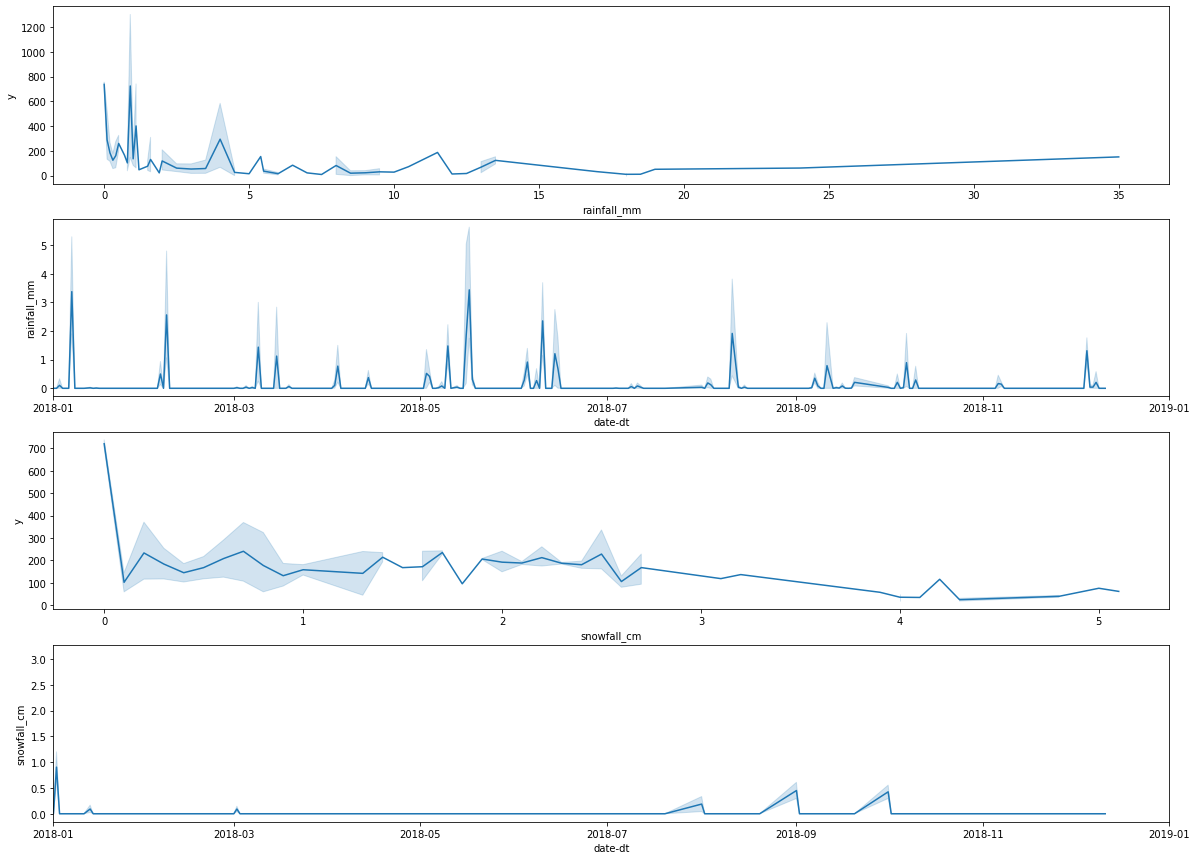

In [17]:
#rainfall and snow fall
fig,ax = plt.subplots(4,figsize = (20,15))
ax1 = sns.lineplot(ax = ax[0],x = train['rainfall_mm'],y=train['y'])

ax2 = sns.lineplot(ax=ax[1],x=train['date-dt'],y=train['rainfall_mm'])
ax2.set_xlim([datetime.date(2018,1,1),datetime.date(2019,1,1)]);

ax3 = sns.lineplot(ax=ax[2],x=train['snowfall_cm'],y=train['y'])

ax4 = sns.lineplot(ax=ax[3],x=train['date-dt'],y=train['snowfall_cm'])
ax4.set_xlim([datetime.date(2018,1,1),datetime.date(2019,1,1)]);

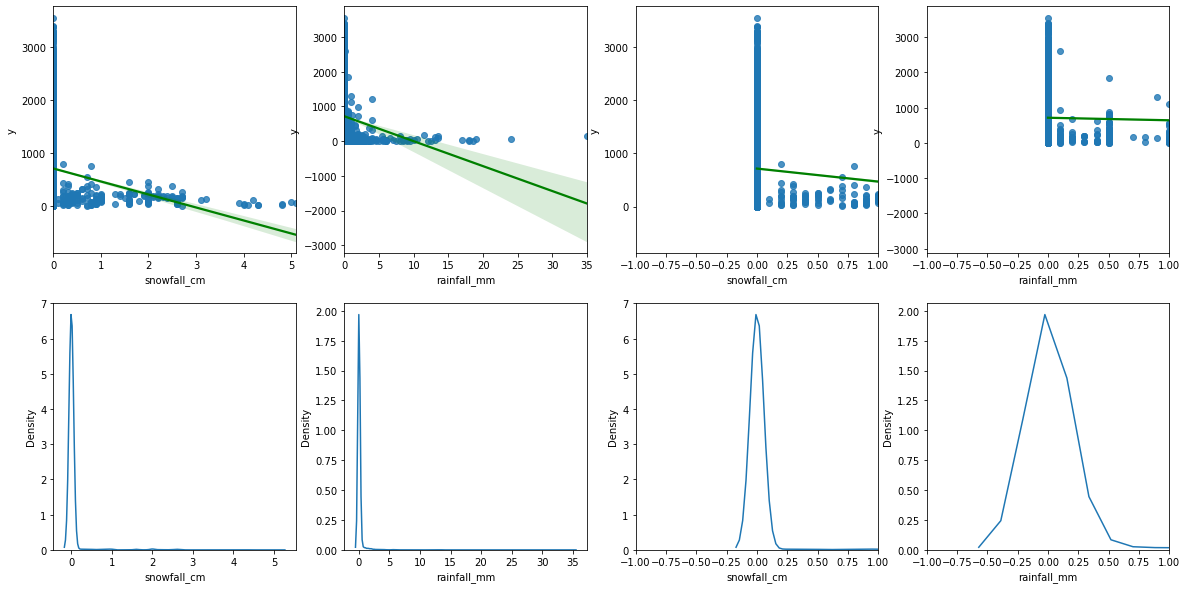

In [18]:
fig,ax = plt.subplots(2,4,figsize=(20,10))
sns.regplot(ax = ax[0,0],x=train['snowfall_cm'],y=train['y'],line_kws={'color':'green'})
sns.regplot(ax=ax[0,1], x=train['rainfall_mm'],y=train['y'],line_kws={'color':'green'})

ax1 = sns.regplot(ax = ax[0,2],x=train['snowfall_cm'],y=train['y'],line_kws={'color':'green'})
ax2 = sns.regplot(ax=ax[0,3], x=train['rainfall_mm'],y=train['y'],line_kws={'color':'green'})
ax1.set_xlim([-1,1]);
ax2.set_xlim([-1,1]);

sns.kdeplot(ax = ax[1,0],x =train['snowfall_cm'])
sns.kdeplot(ax = ax[1,1],x =train['rainfall_mm'])

ax3 = sns.kdeplot(ax = ax[1,2],x =train['snowfall_cm'])
ax4 = sns.kdeplot(ax = ax[1,3],x =train['rainfall_mm'])
ax3.set_xlim([-1,1]);
ax4.set_xlim([-1,1]);



* Rain fall has some meaningfull distribution along the time in opposite to snow fall that has a nearly constant distribution along the time.
* target variable appears to correlate to low snow and rain.
* Rain fall and snow fall have a very narrow distribution around 0.<br><br>
Thoughts:<br>
* droping the snow fall as its doesnt give much information
* keeping rain fall and mayber get t-1

## Wind Speed

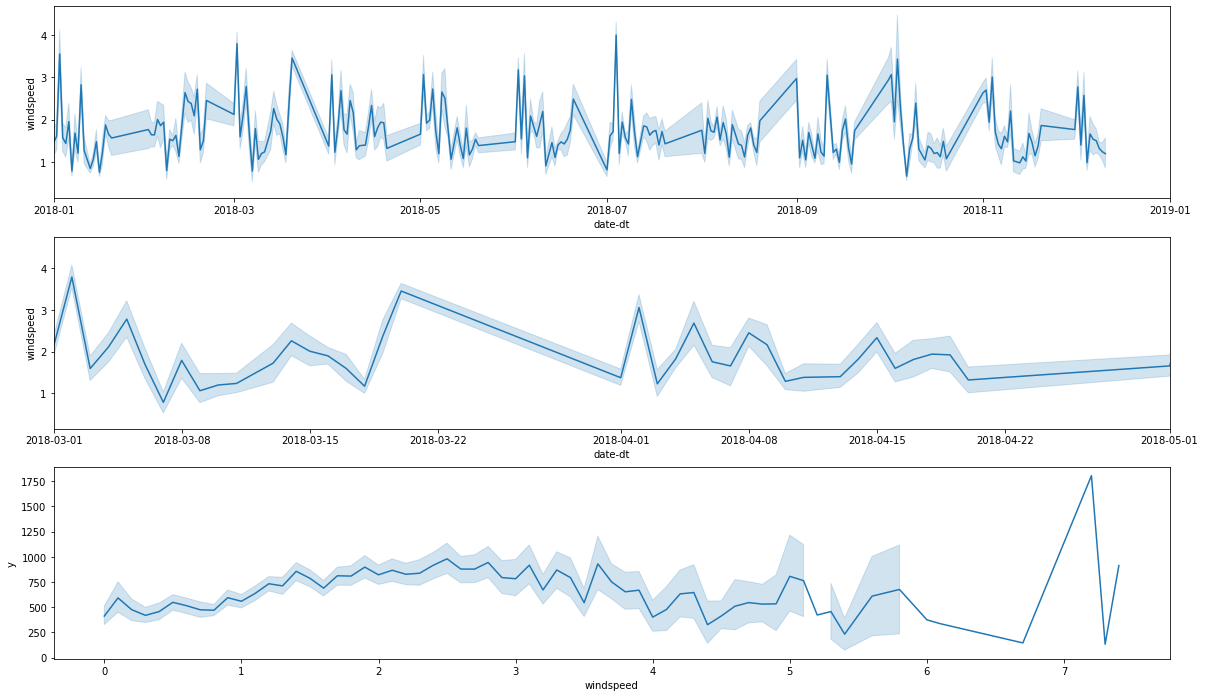

In [19]:
fig,ax = plt.subplots(3,figsize = (20,12))
ax1 = sns.lineplot(ax = ax[0],x=train['date-dt'],y =train['windspeed'])
ax1.set_xlim([datetime.date(2018,1,1),datetime.date(2019,1,1)]);

ax2 = sns.lineplot(ax = ax[1],x=train['date-dt'],y=train['windspeed'])
ax2.set_xlim([datetime.date(2018,3,1),datetime.date(2018,5,1)]);

ax3 = sns.lineplot(ax = ax[2],x=train['windspeed'],y =train['y'])

<AxesSubplot:xlabel='windspeed', ylabel='Density'>

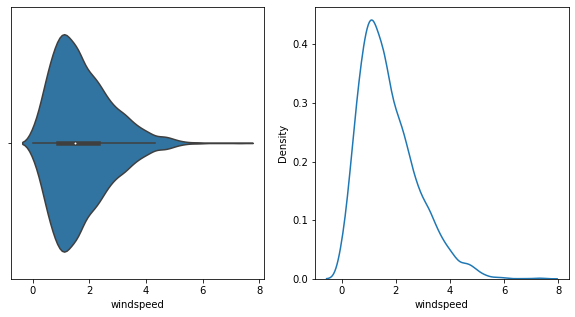

In [20]:
fig,ax = plt.subplots(1,2,figsize = (10,5))
sns.violinplot(ax =ax[0],x=train['windspeed'])
sns.kdeplot(ax = ax[1],x=train['windspeed'])

* bikes tend to be rented around the normal wind speed limits, however it has some outliers around very high wind speed.
* wind speed doesnt seem to follow some trend.

## Numerical features pair plot and distributions.

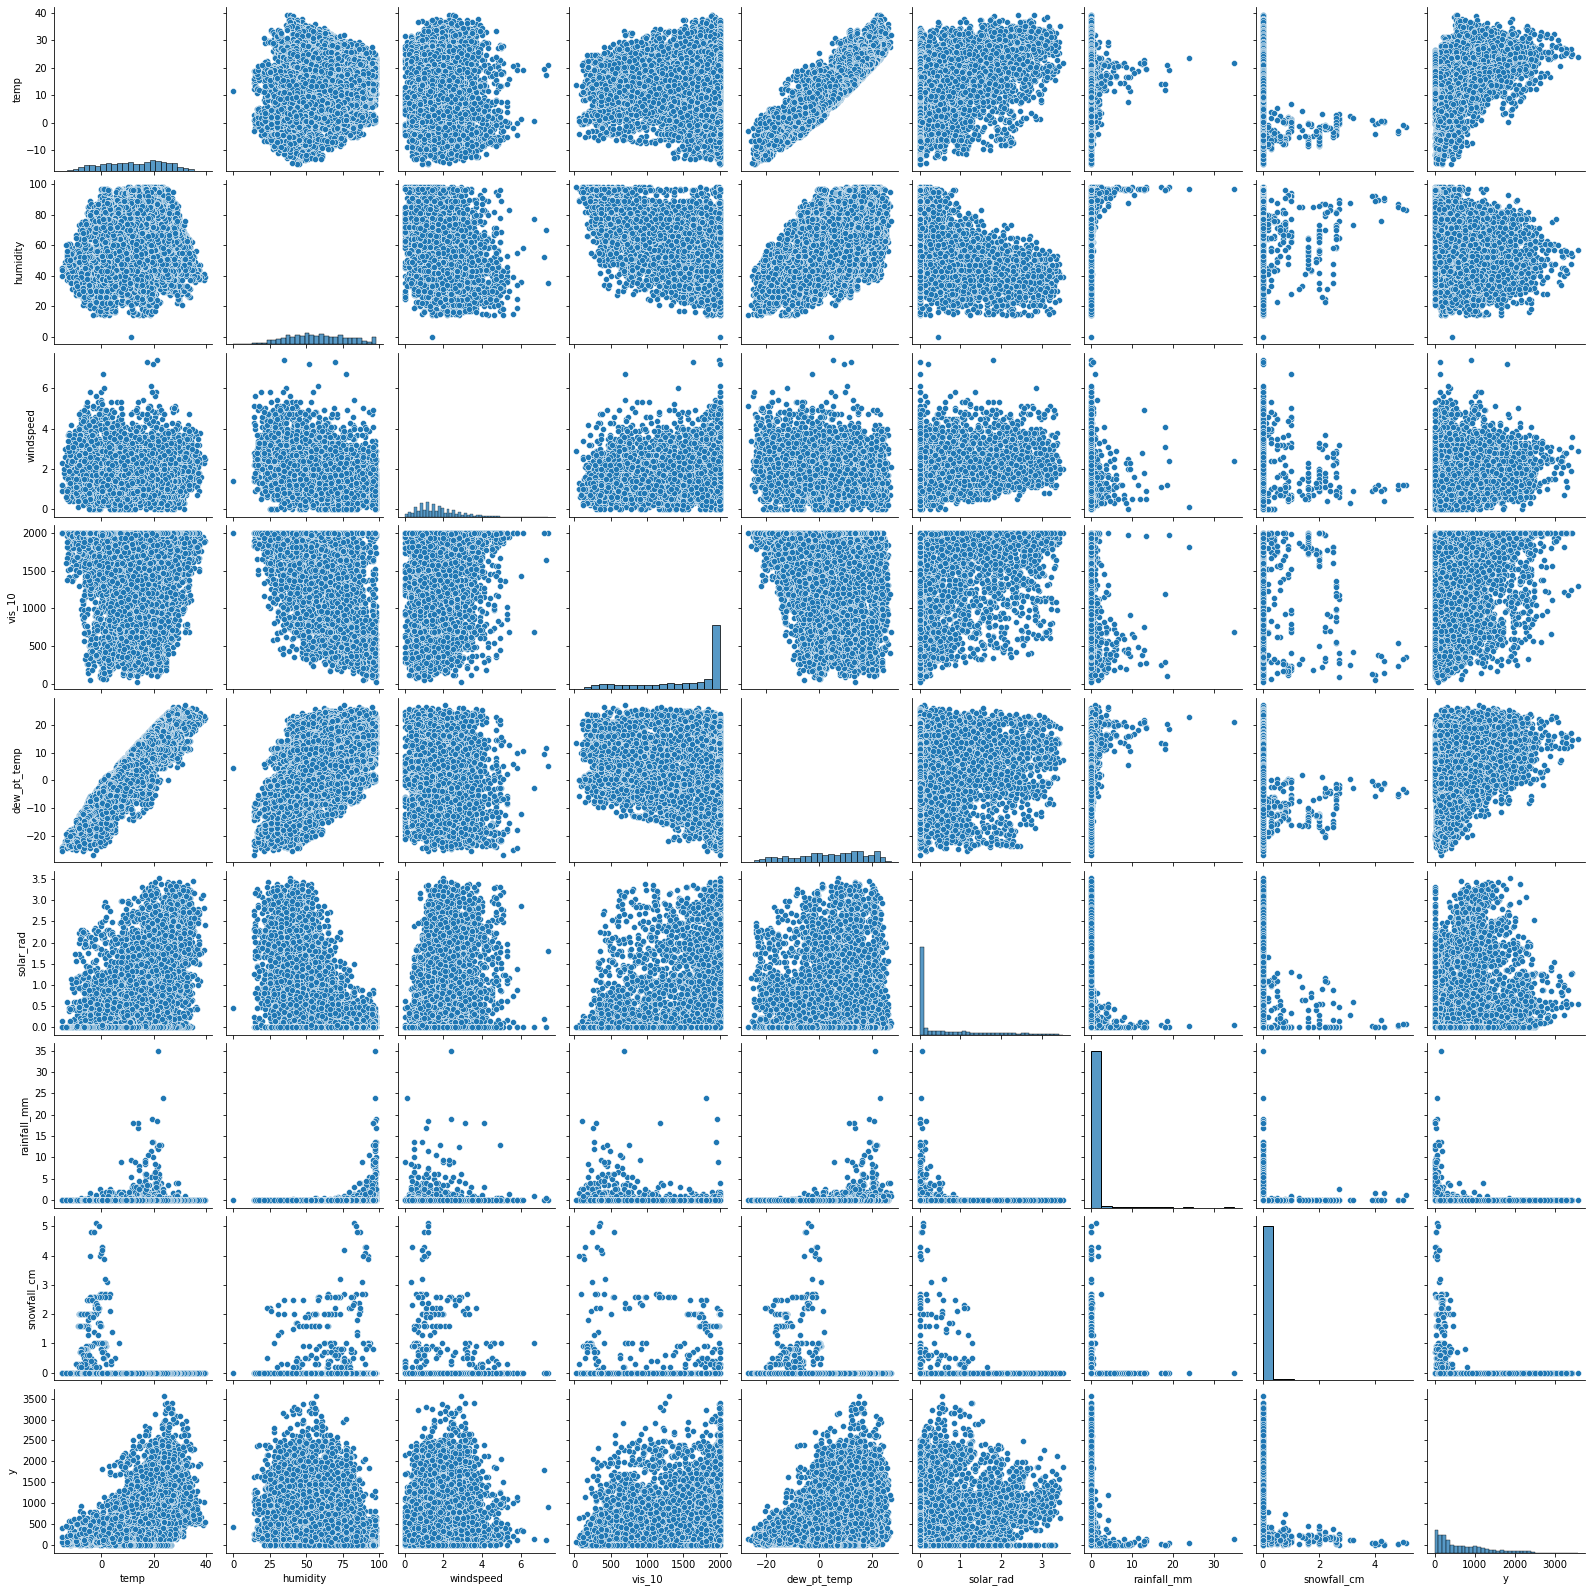

In [21]:
train_numeric_names = ['temp','humidity','windspeed','vis_10','dew_pt_temp','solar_rad','rainfall_mm','snowfall_cm','y']
sns.pairplot(train[train_numeric_names]);

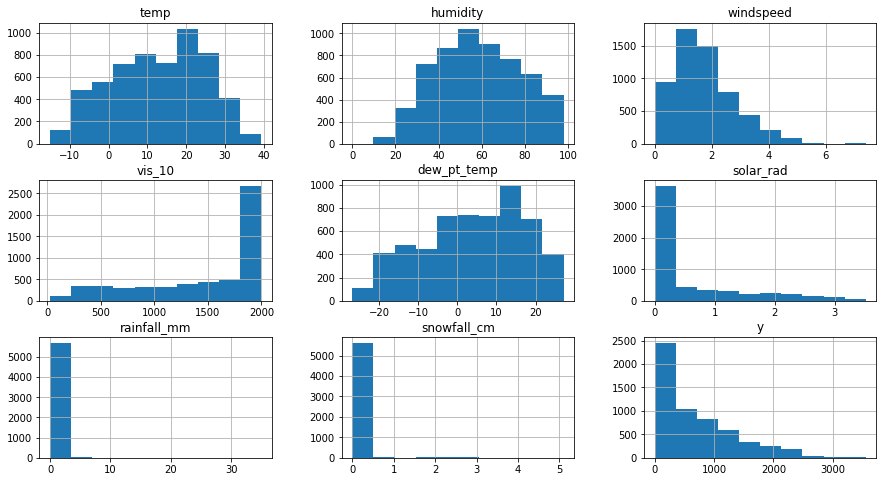

In [22]:
train[train_numeric_names].hist(figsize = (15,8));

## Catagorical features

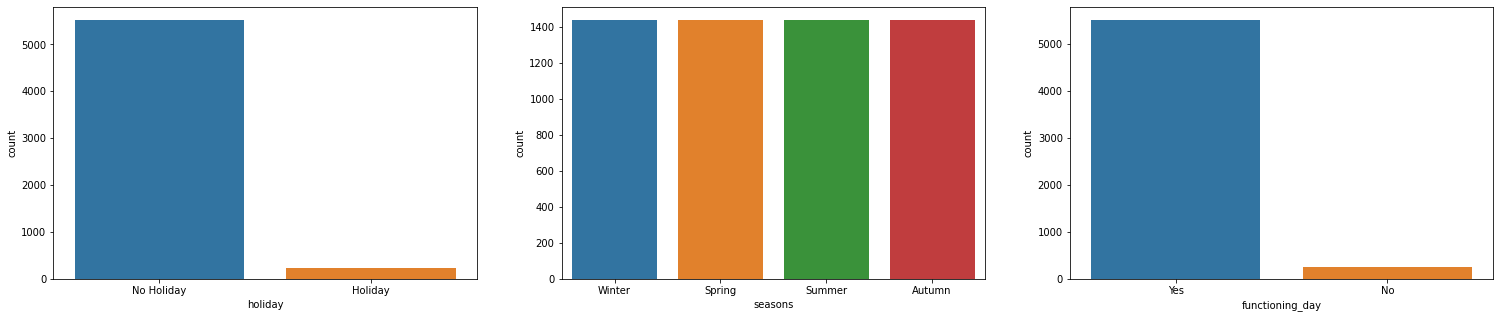

In [23]:
fig,ax = plt.subplots(1,3,figsize = (10,5))
sns.countplot(ax=ax[0],x=train['holiday'])
sns.countplot(ax=ax[1],x=train['seasons'])
sns.countplot(ax=ax[2],x=train['functioning_day'])
plt.subplots_adjust(left=1, right=3 )

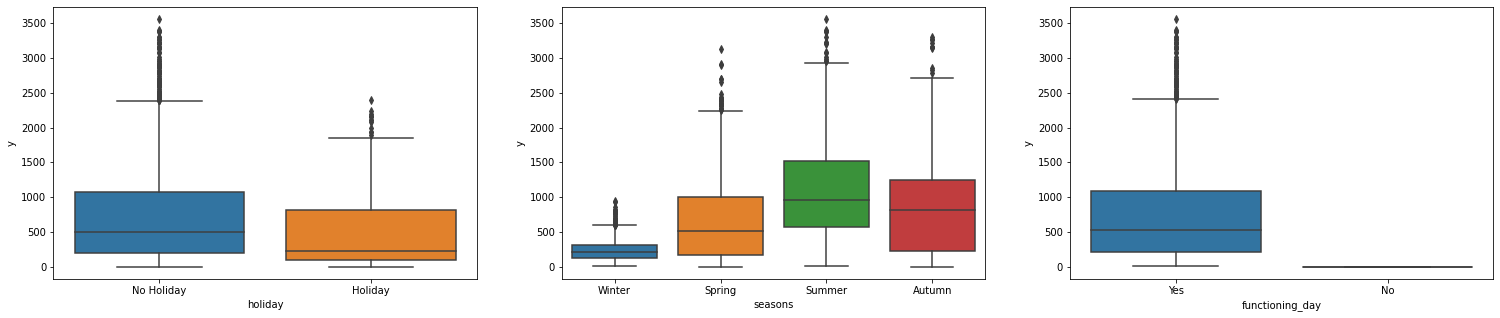

In [24]:
fig,ax = plt.subplots(1,3,figsize = (10,5))
sns.boxplot(ax=ax[0],x=train['holiday'],y=train['y'])
sns.boxplot(ax=ax[1],x=train['seasons'],y=train['y'])
sns.boxplot(ax=ax[2],x=train['functioning_day'],y=train['y'])
plt.subplots_adjust(left=1, right=3 )

<AxesSubplot:xlabel='seasons', ylabel='y'>

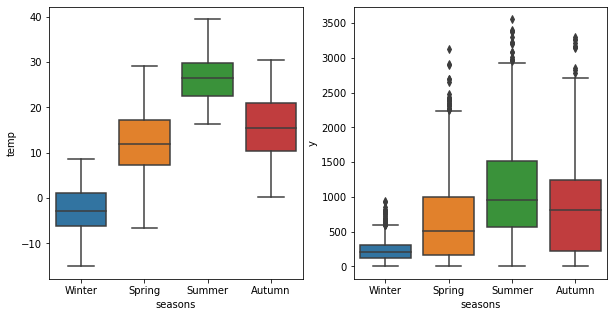

In [25]:
fig,ax = plt.subplots(1,2,figsize = (10,5))
sns.boxplot(ax=ax[0],x=train['seasons'],y=train['temp'])
sns.boxplot(ax=ax[1],x=train['seasons'],y=train['y'])

* Temp varies with seasons ('obviously')
* Rented bikes tend to be the highest around summer and lowest in winter (probably due snow and rain).
* Rented bikes tend to be higher in non holiday days.
* And no bikes is rented in a non functioning day. (no work-closed-).

## Final thoughts:

<ul>
    <li> drop dew temp</li>
    <li> drop snow - or fix </li>
    <li> wind: remove outliers more than 3-4 std and replace them with interpolation</li>
    <li> engineer t-1 column for temp,solar,rain to take advantage of time series</li>
    <li> dummies for seasons</li>
    <li> hours : normalize or get dummies or keep</li>
    <li> dates : get day of the month and the month</li>
    <li> visual : try log scaling</li>
    <li> inspect rolling window and exanding window for time series</li>
</ul>
    

## Aiding lead and lag features.

In [26]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

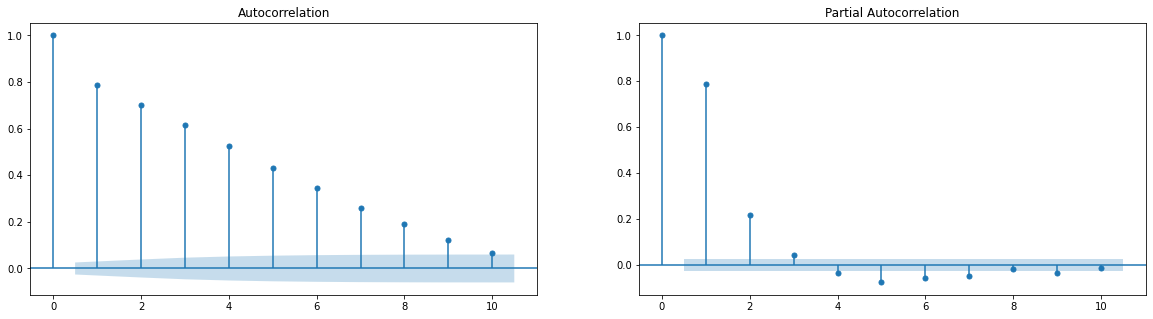

In [27]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
plot_acf(train['windspeed'],lags = 10,ax=ax[0]);
plot_pacf(train['windspeed'],lags = 10,ax=ax[1]);

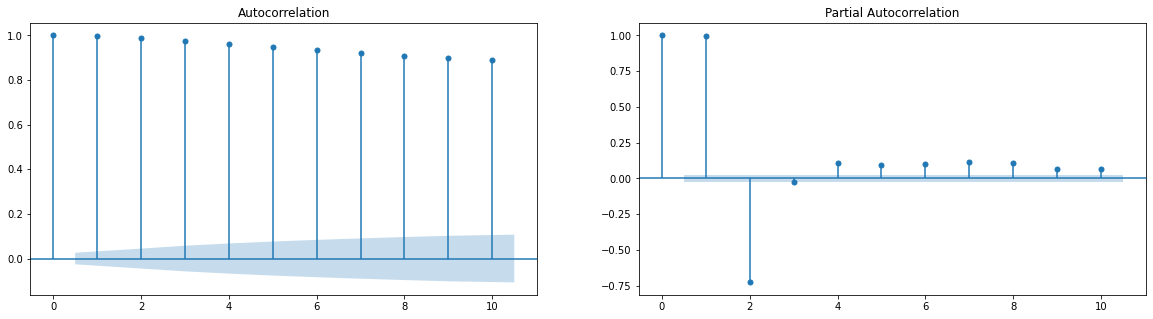

In [28]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
plot_acf(train['temp'],lags = 10,ax=ax[0]);
plot_pacf(train['temp'],lags = 10,ax=ax[1]);

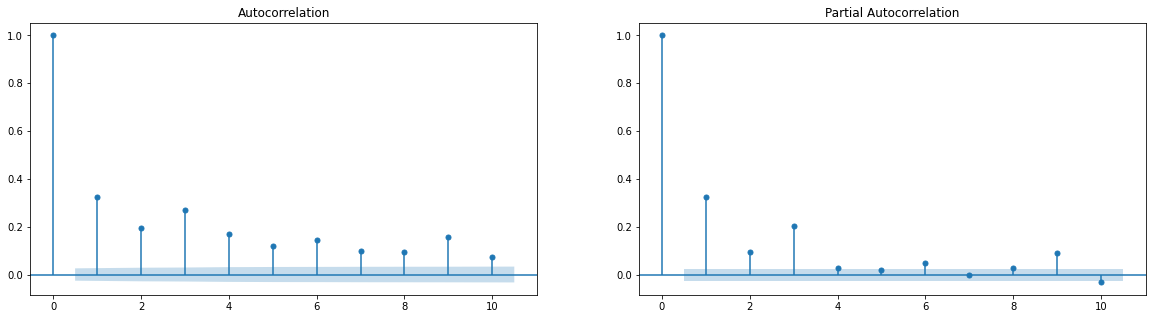

In [29]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
plot_acf(train['rainfall_mm'],lags = 10,ax=ax[0]);
plot_pacf(train['rainfall_mm'],lags = 10,ax=ax[1]);

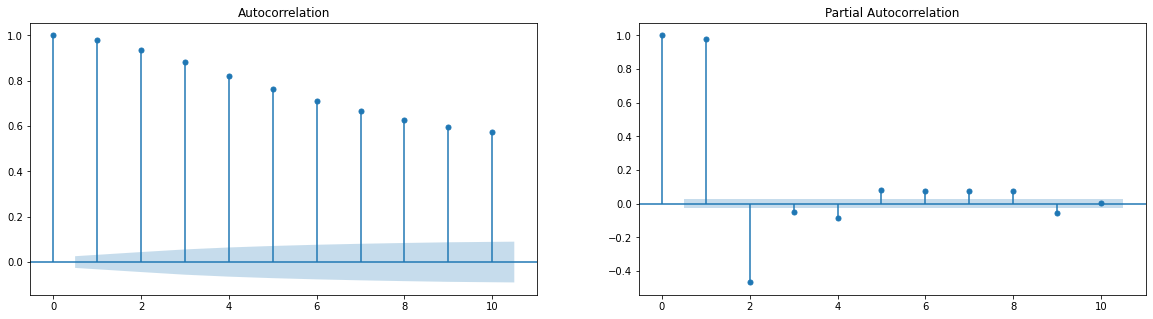

In [30]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
plot_acf(train['snowfall_cm'],lags = 10,ax=ax[0]);
plot_pacf(train['snowfall_cm'],lags = 10,ax=ax[1]);

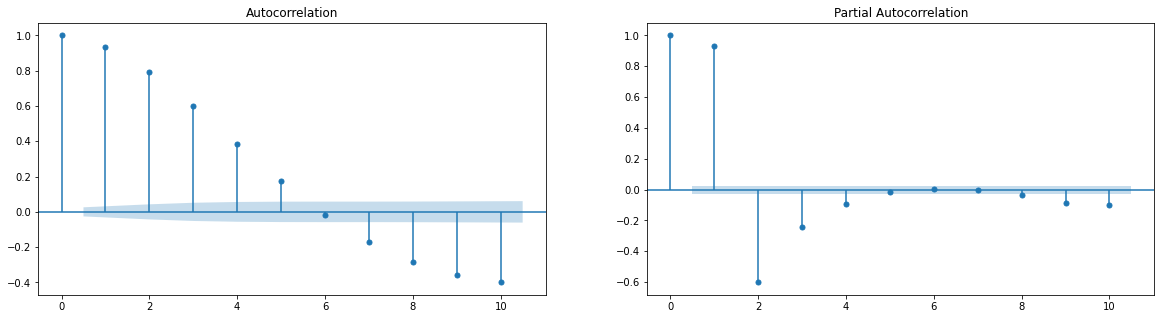

In [31]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
plot_acf(train['solar_rad'],lags = 10,ax=ax[0]);
plot_pacf(train['solar_rad'],lags = 10,ax=ax[1]);

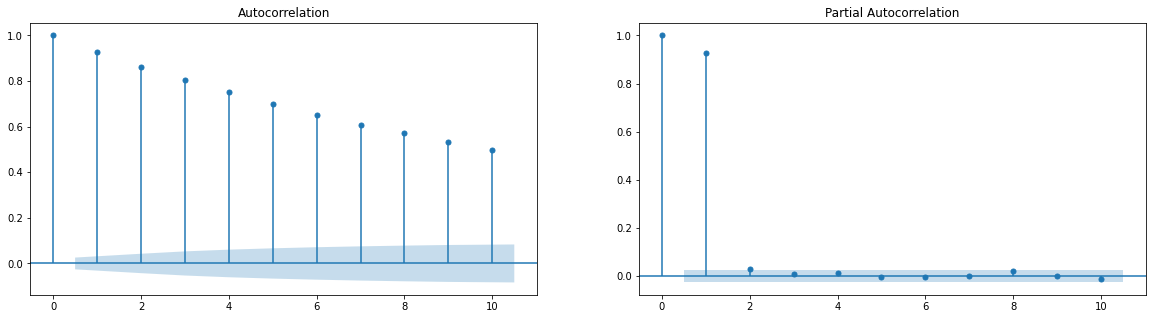

In [32]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
plot_acf(train['vis_10'],lags = 10,ax=ax[0]);
plot_pacf(train['vis_10'],lags = 10,ax=ax[1]);

* It would be a good idea to take laging values for wind,rainfall and solar_rad.
* Try other features too.